In [1]:
%run imports.ipynb

In [39]:
dnmt3a = pd.read_excel('/data/project/SNUH_DNMT3A/data/gangnam_DNMT3A.xlsx', sheet_name='CHIP').rename({'연구번호': 'id'}, axis=1)

dnmt3a = dnmt3a[dnmt3a['id'] != 3].reset_index(drop=True)
dnmt3a.head(3)

,id,Gender,Age,Chr,Pos,Ref,Alt,Gene,Refseq,ExonIndex,Effect,AA,CDS,Targeted,CosmicAll,CosmicTumor,CommVar,dbSNP,TotReadCnt,TotAltCnt,TotRefCnt,TotVaf,KRAF,KRAF2,KRAF3,CST,LVF,BStrand,FILTER1,FILTER2,isSNV
0,9,F,74,chr2,25463589,C,T,DNMT3A,NM_022552.4,18,STOP_GAINED,p.Trp698*,c.2093G>A,True,NaN,NaN,NaN,.,1524,47,1477,3.1,NaN,NaN,NaN,NaN,NaN,True,True,True,False
1,10,F,67,chr2,25457155,C,T,DNMT3A,NM_022552.4,23,NON_SYNONYMOUS_CODING,p.Cys911Tyr,c.2732G>A,True,NaN,NaN,NaN,.,1704,18,1686,1.1,NaN,NaN,NaN,NaN,NaN,True,True,True,False
2,12,F,58,chr2,25463265,G,C,DNMT3A,NM_022552.4,19,NON_SYNONYMOUS_CODING,p.Pro743Arg,c.2228C>G,True,NaN,NaN,NaN,.,1377,32,1345,2.3,NaN,NaN,NaN,NaN,NaN,True,True,True,True


In [38]:
# dnmt3a.to_csv('source_data/chip_dnmt3a.csv', index=False)

In [40]:
dnmt3a = pd.read_csv('source_data/chip_dnmt3a.csv')

In [41]:
stability_data = pd.read_excel('../note2/results/INSTABILITY/huang_stability.xlsx')
instable_positions = set(stability_data[stability_data['Stability ratio (Normalized to DNMT3AWT)'] < 0.75]['order'].values)

def is_ins(pos):
    return pos in instable_positions
    
def classify_dnmt3a_mutation(r):
    if r.Effect in ['STOP_GAINED', 'FRAME_SHIFT']:
        return 'INS'
    elif r.pos == 882:
        return 'R882'
    elif is_ins(r.pos) and r.Effect == 'NON_SYNONYMOUS_CODING':
        return 'INS'
    else:
        return 'Other'

In [110]:
stability_data[stability_data['order'] == 771]

,Unnamed: 0,order,Stability ratio (Normalized to DNMT3AWT)
186,186,771,0.527003


In [42]:
dnmt3a['pos'] = dnmt3a['AA'].str.extract('p.[A-Z][a-z]+([0-9]+)[A-Z][a-z]+').astype(float)
dnmt3a['class'] = dnmt3a.apply(classify_dnmt3a_mutation, axis=1)

In [43]:
# Get DNMT3A amino acid sequence.
out = !curl -s https://rest.uniprot.org/uniprotkb/Q9Y6K1.fasta
seq = ''.join(out[1:])

### Proportion of CHIP

In [181]:
clin_info_full = pd.read_excel('/data/project/SNUH_DNMT3A/data/gangnam_DNMT3A_additional.xlsx')
clin_info_full.shape

(40646, 52)

In [183]:
clin_info_full.ID.nunique()

4573

In [189]:
dnmt3a.id.isin(clin_info_full.ORD_SEQ).all()

True

In [193]:
clin_info_full.ID.nunique() - dnmt3a.id.nunique(), dnmt3a.id.nunique()

(4040, 533)

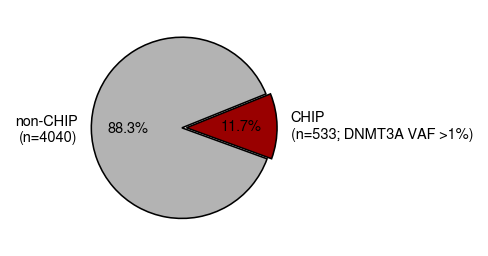

In [206]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(
    [4040, 533],
    labels=['non-CHIP\n(n=4040)', 'CHIP\n(n=533; DNMT3A VAF >1%)'],
    colors=['0.7', '#990000'],
    autopct='%1.1f%%',
    startangle=-20,
    counterclock=False,
    labeldistance=1.15,
    wedgeprops={'linewidth': 0.75, 'edgecolor': 'k'},
    explode=[0.05, 0],
)

save_figures('source_data_figures/chip_analysis/chip_proportion')

### Number of patients in each class

In [147]:
dnmt3a['class'] = pd.Categorical(dnmt3a['class'], categories=['R882', 'INS', 'Other'])

In [146]:
dnmt3a.sort_values('class').groupby('id').agg({'class': 'first'}).value_counts()

class
INS      314
Other    175
R882      44
dtype: int64

In [159]:
dnmt3a.sort_values('class').groupby('id').agg({'class': 'first'}).value_counts(normalize=True)

class
INS      0.589118
Other    0.328330
R882     0.082552
dtype: float64

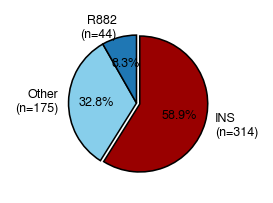

In [208]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(
    [314, 175, 44],
    labels=['INS\n(n=314)', 'Other\n(n=175)', 'R882\n(n=44)'],
    colors=['#990000', 'skyblue', 'C0'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    labeldistance=1.15,
    wedgeprops={'linewidth': 0.75, 'edgecolor': 'k'},
    textprops={'fontsize': 6},
    explode=[0.05, 0, 0],
)

save_figures('source_data_figures/chip_analysis/chip_dnmt3a_subclass_distribution')

### Variant-wise statistics

In [209]:
dnmt3a['class'].value_counts()

INS      354
Other    219
R882      44
Name: class, dtype: int64

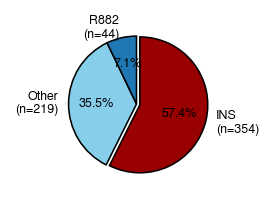

In [210]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(
    [354, 219, 44],
    labels=['INS\n(n=354)', 'Other\n(n=219)', 'R882\n(n=44)'],
    colors=['#990000', 'skyblue', 'C0'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    labeldistance=1.15,
    wedgeprops={'linewidth': 0.75, 'edgecolor': 'k'},
    textprops={'fontsize': 6},
    explode=[0.05, 0, 0],
)

save_figures('source_data_figures/chip_analysis/chip_dnmt3a_variant_distribution')

In [100]:
is_ins(777)

True

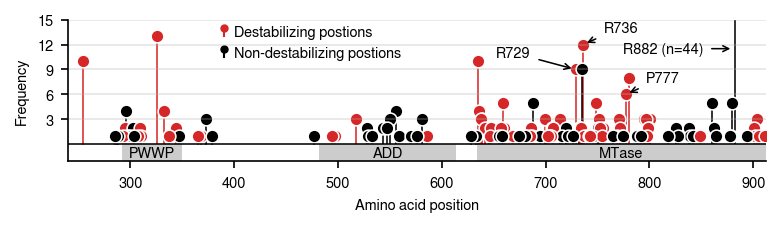

In [45]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(6, 1.25))
ax = fig.add_subplot(111)
ax.grid(axis='y', alpha=0.33)

t = dnmt3a[(dnmt3a.pos != 334) & (dnmt3a.Effect == 'NON_SYNONYMOUS_CODING')].pos.value_counts()

xs = t.index.values
ys = t.values

for x, y in zip(t.index.values, t.values):
    ax.plot([x, x], [0, y], lw=0.75, c='C3' if is_ins(x) else 'k', zorder=-1)
        
for x, y in zip(t.index.values, t.values):
    if is_ins(x):
        ax.scatter([x], [y], c='C3', s=150, edgecolors='w', lw=0.75)
        
        # Annotate 688, 729, 735, 736, 777.
        if x in [736, 735, 777]:
            ax.annotate(f'{seq[int(x) - 1]}{int(x)}', (x, y), (x + 20, y + 2), color='k', arrowprops={'arrowstyle': '->', 'lw': 0.75, 'color': 'k'}, va='center', ha='left')
        if x in [729, 688]:
            ax.annotate(f'{seq[int(x) - 1]}{int(x)}', (x, y), (x - 60, y + 2), color='k', arrowprops={'arrowstyle': '->', 'lw': 0.75, 'color': 'k'}, va='center', ha='center')
    else:
        ax.scatter([x], [y], c='k', s=150, edgecolors='w', lw=0.75)
        
ax.annotate(f'R882 (n={t.loc[882]})', (882, 11.5), (882 - 30, 11.5), color='k', arrowprops={'arrowstyle': '->', 'lw': 0.75, 'color': 'k'}, va='center', ha='right')

domain_height = 2

rect = patches.Rectangle((292, -domain_height), 350 - 292, domain_height, linewidth=0.75, edgecolor='none', facecolor='0.8')
ax.add_patch(rect)
ax.text((292 + 350) // 2, -domain_height / 1.9, 'PWWP', ha='center', va='center')

rect = patches.Rectangle((482, -domain_height), 614 - 482, domain_height, linewidth=0.75, edgecolor='none', facecolor='0.8')
ax.add_patch(rect)
ax.text((482 + 614) // 2, -domain_height / 1.9, 'ADD', ha='center', va='center')

rect = patches.Rectangle((634, -domain_height), 912 - 634, domain_height, linewidth=0.75, edgecolor='none', facecolor='0.8')
ax.add_patch(rect)
ax.text((634 + 912) // 2, -domain_height / 1.9, 'MTase', ha='center', va='center')

ax.plot([390, 390], [13, 14], lw=1, c='C3')
ax.scatter(390, 14, c='C3')
ax.text(400, 13.5, 'Destabilizing postions', va='center')

ax.plot([390, 390], [10.5, 11.5], lw=1, c='k')
ax.scatter(390, 11.5, c='k')
ax.text(400, 11, 'Non-destabilizing postions', va='center')

ax.axhline(0, lw=0.75, c='k')

ax.set_yticks(np.arange(3, 16, 3))
ax.set_xlim([240, 912])
ax.set_ylim(-domain_height, 15)

for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
    
ax.set_xlabel('Amino acid position')
ax.set_ylabel('Frequency')

save_figures('source_data_figures/chip_analysis/mutation_distribution_gangnam')

In [58]:
stats.mannwhitneyu(
    d[d['class'] == 'Other'].VAF,
    d[d['class'] == 'R882'].VAF,
)

MannwhitneyuResult(statistic=3933.5, pvalue=0.02680240459507789)

In [134]:
dnmt3a['class'].value_counts()

INS      354
Other    219
R882      44
Name: class, dtype: int64

INS vs Other p= 5.990478720020085e-05
INS vs R882 p= 0.44825199310010694
R882 vs Other p= 0.02680240459507789


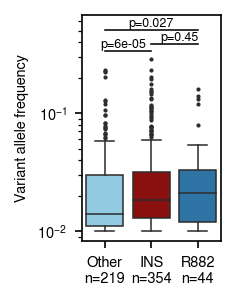

In [211]:
box_kws = {
    'order': ['Other', 'INS', 'R882'],
    'palette': ['skyblue', '#990000', 'C0'],
    'saturation': 0.8,
    'flierprops': {'marker': '.', 'markersize': 2}
}

d = dnmt3a.copy()
d['VAF'] = d.TotVaf / 100

fig = plt.figure(figsize=(1.2, 2))
ax = fig.add_subplot(111)

sns.boxplot(data=d, x='class', y='VAF', **box_kws)

ymax = d.VAF.max()
dy = 5e-2

ax.plot([0, 1], [ymax + dy, ymax + dy], c='k')
ax.plot([1, 2], [ymax + dy * 2, ymax + dy * 2], c='k')
ax.plot([0, 2], [ymax + dy * 4.5, ymax + dy * 4.5], c='k')

# INS vs Other
stat, p = stats.mannwhitneyu(
    d[d['class'] == 'Other'].VAF,
    d[d['class'] == 'INS'].VAF,
)
print('INS vs Other p=', p)
ax.text(0.4, ymax + dy, f'p={p:.2g}', ha='center', va='bottom', fontsize=6)

# INS vs R882
stat, p = stats.mannwhitneyu(
    d[d['class'] == 'R882'].VAF,
    d[d['class'] == 'INS'].VAF,
)
print('INS vs R882 p=', p)
ax.text(1.6, ymax + dy * 2, f'p={p:.2g}', ha='center', va='bottom', fontsize=6)

# R882 vs Other
stat, p = stats.mannwhitneyu(
    d[d['class'] == 'Other'].VAF,
    d[d['class'] == 'R882'].VAF,
)
print('R882 vs Other p=', p)
ax.text(1, ymax + dy * 4.5, f'p={p:.2g}', ha='center', va='bottom', fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Variant allele frequency')
ax.set_yscale('log')

ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 1.1])

ax.set_xticklabels([
    f'Other\nn={len(d[d["class"] == "Other"])}',
    f'INS\nn={len(d[d["class"] == "INS"])}',
    f'R882\nn={len(d[d["class"] == "R882"])}',
])

save_figures('source_data_figures/chip_analysis/vaf_box')

### Mutation rate 구하기

chr2:25,450,743-25,565,459 (hg19)

In [65]:
mutation_rate = pd.read_excel('../note2/results/INSTABILITY-FITNESS/site_specific_mutation_rate.xlsx')

In [67]:
trinuc2mutrate = mutation_rate.groupby('site_from').sum('site_specific_mutation_rate')['site_specific_mutation_rate'].to_dict()

In [68]:
hg19 = SeqIO.to_dict(SeqIO.parse('/data/project/dohoon/reference/hg19/hg19.fa', 'fasta'))

In [69]:
get_base = lambda pos: hg19['chr2'][pos - 1].upper()

ref_trinuc, alt_trinuc = [], []
for r in dnmt3a.to_records():
    ref_trinuc.append(hg19['chr2'][int(r.Pos - 2)] + r.Ref + hg19['chr2'][int(r.Pos)])
    alt_trinuc.append(hg19['chr2'][int(r.Pos - 2)] + r.Alt + hg19['chr2'][int(r.Pos)])
    
dnmt3a['ref_trinuc'] = ref_trinuc
dnmt3a['alt_trinuc'] = alt_trinuc

In [70]:
dnmt3a_merged = dnmt3a.merge(mutation_rate, left_on=['ref_trinuc', 'alt_trinuc'], right_on=['site_from', 'site_to'])

In [71]:
mu_ins = dnmt3a_merged[dnmt3a_merged['class'] == 'INS'].drop_duplicates(['Pos', 'Ref', 'Alt']).site_specific_mutation_rate.sum() * 1e-9
mu_ins

4.924900000000001e-07

In [72]:
mu_other = dnmt3a_merged[(dnmt3a_merged['class'] == 'Other') & (dnmt3a_merged['Effect'] == 'NON_SYNONYMOUS_CODING') & (dnmt3a_merged.pos != 334)].drop_duplicates(['Pos', 'Ref', 'Alt']).site_specific_mutation_rate.sum() * 1e-9
mu_other

2.4799e-07

In [73]:
mu_R882 = dnmt3a_merged[dnmt3a_merged['class'] == 'R882'].drop_duplicates(['Pos', 'Ref', 'Alt']).site_specific_mutation_rate.sum() * 1e-9
mu_R882

3.5419999999999996e-08

### Cohort size, age distribution

In [74]:
clin_info_additional = pd.read_excel('/data/project/SNUH_DNMT3A/data/gangnam_DNMT3A_additional.xlsx')
clin_info_additional.shape

(40646, 52)

In [75]:
clin_info_additional.drop_duplicates('ORD_SEQ')['연령'].mean(), clin_info_additional.drop_duplicates('ORD_SEQ')['연령'].std()

(52.2890881259567, 8.444919907467687)

In [76]:
clin_info_additional.drop_duplicates('ORD_SEQ')['연령'].min(), clin_info_additional.drop_duplicates('ORD_SEQ')['연령'].max()

(34, 87)

In [78]:
clin_info_additional.ORD_SEQ.nunique()

4573

In [79]:
dnmt3a['ref_base'] = dnmt3a.Pos.map(get_base)

In [80]:
import math

# DNMT3A R882H mutation rate
R882H_mu = 1.88229e-08
mu = 8.47e-06

# Histogram parameters
binmethod = 'doane'

# Total participants in the study
study_total = 4573

def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

def normalised_VAF_normalised_densities_list(trimmed_VAF_list, study_total, mu, binmethod):
    y1 = []
    for i in trimmed_VAF_list:
        VAFs = float(i)
        y = np.log(VAFs)
        y1.append(y)
        
    normed_value = study_total * 2 * mu
    hist, bins = np.histogram(y1, bins=binmethod, range=(min(y1), max(y1)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist / (normed_value * widths)
    log_hist_for_plot = np.log(normalised_hist)

    errors = error_bars(hist, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    return VAF_densities  

In [81]:
dnmt3a[(dnmt3a['class'] == 'R882') & (dnmt3a['Effect'] == 'NON_SYNONYMOUS_CODING') & (dnmt3a_merged.pos != 334)].sort_values('TotVaf')[['AA', 'TotVaf']].tail(20)

,AA,TotVaf
53,p.Arg882Cys,2.4
472,p.Arg882Cys,2.4
461,p.Arg882Cys,2.5
231,p.Arg882His,2.5
368,p.Arg882His,2.6
349,p.Arg882Cys,2.7
390,p.Arg882His,2.8
36,p.Arg882His,3.1
263,p.Arg882His,3.3
239,p.Arg882His,3.3


In [82]:
import warnings
warnings.filterwarnings('ignore')

R882H_densities = normalised_VAF_normalised_densities_list(dnmt3a[dnmt3a.AA == 'p.Arg882His'].TotVaf.values / 100, study_total, R882H_mu, binmethod)
R882H_densities = [x for x in R882H_densities if np.isfinite(x[1])]

INS_densities = normalised_VAF_normalised_densities_list(dnmt3a[dnmt3a['class'] == 'INS'].TotVaf.values / 100, study_total, mu_ins, binmethod)
INS_densities = [x for x in INS_densities if np.isfinite(x[1])]

other_densities = normalised_VAF_normalised_densities_list(dnmt3a[(dnmt3a['class'] == 'Other') & (dnmt3a['Effect'] == 'NON_SYNONYMOUS_CODING') & (dnmt3a_merged.pos != 334)].TotVaf.values / 100, study_total, mu_other, binmethod)
other_densities = [x for x in other_densities if np.isfinite(x[1])]

R882_densities = normalised_VAF_normalised_densities_list(dnmt3a[dnmt3a['class'] == 'R882'].TotVaf.values / 100, study_total, mu_R882, binmethod)
R882_densities = [x for x in R882_densities if np.isfinite(x[1])]

In [83]:
#MLE function for range of ages
#l=ln(f)

def logProbtheory_ages(l, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    N = 1e5
    s = params[0]
    sigma = 8.444919907467687
    mean = 52.2890881259567

    total_density=integrate.quad(lambda t: (N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*\
                                 ((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2))))), mean-2*sigma, mean+2*sigma)
    return np.log(total_density[0])

def logProbDataGivenModel_ages(params, data):
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    ages = np.linspace(34, 87, 87-34+1)
    
    for age in ages:
        for datapoint in data:
            
            if np.exp(datapoint[0])<0.5:
                logfreq = datapoint[0]
                predicted_log_density = logProbtheory_ages(logfreq, params)
                
                square_distance = ((datapoint[1] - predicted_log_density)**2)
                total_square_distance = total_square_distance + square_distance
    return total_square_distance   

In [89]:
import scipy
from scipy import integrate
 
initial_guess = [0.13]

scipy.optimize.minimize(logProbDataGivenModel_ages, initial_guess, args=(R882H_densities,), method='Nelder-Mead')  

 final_simplex: (array([[0.15353711],
       [0.15351172]]), array([138.06148077, 138.06150234]))
           fun: 138.06148076593493
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([0.15353711])

In [90]:
def logProbtheory_ages_nonsyn_exp_power(l, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0

#     N, s, sigma = [2.77368259e+05, 1.13187834e-01, 2.61729603e+01]
    N, s, sigma = 1e5, 0.15353711, 8.444919907467687
    mean = 52.2890881259567
    
#     N = 1e5
#     sigma = 8.736075979542486
    s_peak = 0.0
    b = params[0]
    d = params[1]
    s_max=params[2]

    dt = 0.1

    weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
    normalization=integrate.quad(weight_s, 0.0, s_max)
    normalized_rho_s= lambda s: (1.0/normalization[0])*np.exp(-((abs(s-s_peak))/d)**b)
    
    rho=lambda t,s: (normalized_rho_s(s))*(N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2)))))

    total_density=integrate.dblquad(rho, 0.0, s_max, lambda s: mean-2*sigma, lambda s: mean+2*sigma)

    return np.log(total_density[0])

def logProbDataGivenModel_ages_nonsyn_exp_power(params, data): 
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        if np.exp(datapoint[0])<0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_ages_nonsyn_exp_power(logfreq, params)
            square_distance = ((datapoint[1] - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance

    return total_square_distance   

In [ ]:
initial_guess=[0.8, 0.014, 0.25] #initial guess for [b, d, s_max]

ins_res = scipy.optimize.minimize(
    logProbDataGivenModel_ages_nonsyn_exp_power, initial_guess, args=(INS_densities,), method='Nelder-Mead',
    options={'maxiter': 1000, 'maxfev': 1000}
)
print('ins fitting done!')

other_res = scipy.optimize.minimize(
    logProbDataGivenModel_ages_nonsyn_exp_power, initial_guess, args=(other_densities,), method='Nelder-Mead',
    options={'maxiter': 1000, 'maxfev': 1000}
)
print('other fitting done!')

r882_res = scipy.optimize.minimize(
    logProbDataGivenModel_ages_nonsyn_exp_power, initial_guess, args=(R882_densities,), method='Nelder-Mead',
    options={'maxiter': 1000, 'maxfev': 1000}
)
print('R882 fitting done!')

In [95]:
N, s, sigma = 1e5, 0.15353711, 8.444919907467687
x = np.linspace(-10, -0.7, 500)

R882H_y = [np.exp(logProbtheory_ages(l, [s])) for l in x]

R882_y = [np.exp(logProbtheory_ages_nonsyn_exp_power(l, r882_res.x)) for l in x]
INS_y = [np.exp(logProbtheory_ages_nonsyn_exp_power(l, ins_res.x)) for l in x]
other_y = [np.exp(logProbtheory_ages_nonsyn_exp_power(l, other_res.x)) for l in x]

In [ ]:
fig = plt.figure(figsize=(3 * 0.8, 2 * 0.8))
ax = fig.add_subplot(111)

line_kws = {
    'lw': 0.75,
    'zorder': -10,
}
ax.plot(np.exp(x), R882_y, **line_kws)
ax.plot(np.exp(x), INS_y, c='C3', **line_kws)
ax.plot(np.exp(x), other_y, c='skyblue', **line_kws)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e-4, 0.7])
ax.set_ylim([1, 5e5])


errorbar_kws = {
    'capsize': 0.75,
    'elinewidth': 0.375,
#     'capthick': 0.2,
    'markersize': 2,
    'markeredgewidth': 0.75,
}
ax.errorbar(
    [np.exp(x[0]) for x in R882H_densities],
    [np.exp(x[1]) for x in R882H_densities],
    yerr=[[np.exp(x[1]) - np.exp(x[1] - x[2]) for x in R882H_densities], [np.exp(x[1] + x[3]) - np.exp(x[1]) for x in R882H_densities]],
    c='C0',
    fmt='o',
    zorder=0,
    label='R882H',
    **errorbar_kws,
)

ax.errorbar(
    [np.exp(x[0]) for x in other_densities],
    [np.exp(x[1]) for x in other_densities],
    yerr=[[np.exp(x[1]) - np.exp(x[1] - x[2]) for x in other_densities], [np.exp(x[1] + x[3]) - np.exp(x[1]) for x in other_densities]],
    c='skyblue',
    fmt='s',
    zorder=1,
    label='Other',
    **errorbar_kws,
)


ax.errorbar(
    [np.exp(x[0]) for x in INS_densities],
    [np.exp(x[1]) for x in INS_densities],
    yerr=[[np.exp(x[1]) - np.exp(x[1] - x[2]) for x in INS_densities], [np.exp(x[1] + x[3]) - np.exp(x[1]) for x in INS_densities]],
    c='#990000',
    fmt='^',
    zorder=2,
    label='INS',
    **errorbar_kws,
)

ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 0.5], minor=False)
ax.set_xticklabels([0.01, 0.1, 1, 10, 50])

handles = [
    mpl.lines.Line2D([0], [0], marker = 'o', color = 'C0', lw=0, label='R882H'),
    mpl.lines.Line2D([0], [0], marker = '^', color = '#990000', lw=0, label='INS'),
    mpl.lines.Line2D([0], [0], marker = 's', color = 'Skyblue', lw=0, label='Other'),
]
ax.legend(handles=handles, frameon=False, markerscale=0.75, fontsize=6, handletextpad=0)

ax.set_xlabel('Variant allele frequency (%)')
ax.set_ylabel('Relative density of variants')

save_figures('source_data_figures/chip_analysis/fitness')